In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
from sklearn.linear_model import LogisticRegression
import itertools


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
def evaluate(classes,y_true,y_pred,normalize=True):
    print (classification_report(y_true, y_pred))
    print ("roc_auc_score : %f " % metrics.roc_auc_score(y_true, y_pred))
    
    cmap=plt.cm.Blues
    cm=confusion_matrix(y_true,y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    f, axarr = plt.subplots(1,2,figsize=(12,4))
    # plot confusion matrix
    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()
    
    # plot roc curve
    plt.subplot(1, 2, 2)
    fpr,tpr,_ = roc_curve(y_true,y_pred)
    auc = metrics.roc_auc_score(y_true,y_pred)
    plt.plot(fpr,tpr,label="roc_auc_score : %f "% auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend(loc=4)
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()

In [3]:
data = pd.read_json("data/train.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)
data=data.drop(['requester_user_flair'], axis=1)
data=data.drop(['requester_days_since_first_post_on_raop_at_retrieval'], axis=1)
#data=data.drop(['requester_account_age_in_days_at_request'], axis=1)
data=data.drop(['requester_account_age_in_days_at_retrieval'], axis=1)
data=data.drop(['number_of_downvotes_of_request_at_retrieval'], axis=1)
data=data.drop(['number_of_upvotes_of_request_at_retrieval'], axis=1)
data=data.drop(['post_was_edited'], axis=1)
data=data.drop(['request_number_of_comments_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_comments_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_comments_in_raop_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_posts_at_retrieval'], axis=1)
data=data.drop(['requester_number_of_posts_on_raop_at_retrieval'], axis=1)
data=data.drop(['requester_upvotes_minus_downvotes_at_retrieval'], axis=1)
data=data.drop(['requester_upvotes_plus_downvotes_at_retrieval'], axis=1)

In [4]:
data.groupby(['requester_received_pizza']).size()

requester_received_pizza
False    3046
True      994
dtype: int64

### Balance the classes by oversampling the success label

In [5]:
data.groupby(['requester_received_pizza']).size()

requester_received_pizza
False    3046
True      994
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

train_data, dev_data = train_test_split(data, test_size=0.3)

#over sample train data
train_data_fail = train_data[train_data['requester_received_pizza'] == 0]
train_data_success = train_data[train_data['requester_received_pizza'] == 1]
train_data = pd.concat([train_data_fail, train_data_success,
                     train_data_success, train_data_success], axis = 0)


In [7]:
print (train_data.groupby(['requester_received_pizza']).size())

train_labels = train_data["requester_received_pizza"]
dev_labels = dev_data["requester_received_pizza"]
train_data=train_data.drop(['requester_received_pizza'], axis=1)
dev_data=dev_data.drop(['requester_received_pizza'], axis=1)

train_data_text = train_data["request_text"]
train_data=train_data.drop(['request_text'], axis=1)
dev_data_text = dev_data["request_text"]
dev_data=dev_data.drop(['request_text'], axis=1)

print (train_data.shape)
print (train_data_text.shape)
print (dev_data.shape)
print (dev_data_text.shape)

requester_received_pizza
False    2133
True     2085
dtype: int64
(4218, 13)
(4218,)
(1212, 13)
(1212,)


In [8]:
train_data.head(1)

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,year,month,day,dayofweek
2457,91.798958,91.790625,195,1,31,1,28,442,626,2012,7,23,0


In [9]:
class_names = ['No-Pizza','Pizza']
import string
def better_preprocessor(s):
    if len(s)>1: 
      for char in string.punctuation:
         s = s.replace(char, ' ').lower()
    elif (s.isdigit()):
        s = ' '
    else: s=' '        
    return s

In [10]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = str_input.split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [11]:
vectorizer = TfidfVectorizer(stop_words='english',
                     preprocessor=better_preprocessor
                     #,tokenizer=stemming_tokenizer
                      ,min_df=2, 
                      max_df=0.5, 
                     ngram_range=(1,1)       
                     )
X = vectorizer.fit_transform(train_data_text)
print (len(vectorizer.get_feature_names()))

6231


In [12]:
#Fit Logistic Regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='lbfgs',C=0.21,
multi_class='multinomial',class_weight='balanced').fit(X,train_labels)
features=vectorizer.get_feature_names()

In [13]:
from sklearn import metrics

X_dev = vectorizer.transform(dev_data_text)
predicted = clf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score for Logistic Regression Classifier : %r' % f)


F1 Score for Logistic Regression Classifier : 0.6542527656809434


              precision    recall  f1-score   support

       False       0.79      0.70      0.75       913
        True       0.33      0.44      0.37       299

   micro avg       0.64      0.64      0.64      1212
   macro avg       0.56      0.57      0.56      1212
weighted avg       0.68      0.64      0.65      1212

roc_auc_score : 0.571199 


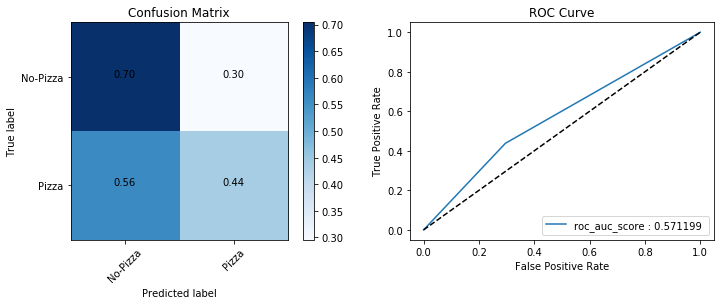

In [14]:
evaluate(class_names,dev_labels,predicted,True)

In [15]:
from sklearn.model_selection import GridSearchCV

param_range=[0.0001,0.0005,0.001]
parameters = {'C': param_range, 'solver':['lbfgs'] }

gs_clf=GridSearchCV(clf, parameters, cv=5, iid=False, n_jobs=-1,scoring='roc_auc')
gs_clf = gs_clf.fit(X, train_labels)

In [16]:
gs_clf.best_params_

{'C': 0.001, 'solver': 'lbfgs'}

In [17]:
lr_clf = gs_clf.best_estimator_
predicted = lr_clf.predict(X_dev)
dev_probs=lr_clf.predict_proba(X_dev)
predicted=[True if dev_probs[k][1] > 0.50 else False for k in range(len(dev_probs))]

              precision    recall  f1-score   support

       False       0.81      0.68      0.74       913
        True       0.35      0.51      0.41       299

   micro avg       0.64      0.64      0.64      1212
   macro avg       0.58      0.60      0.58      1212
weighted avg       0.70      0.64      0.66      1212

roc_auc_score : 0.596459 


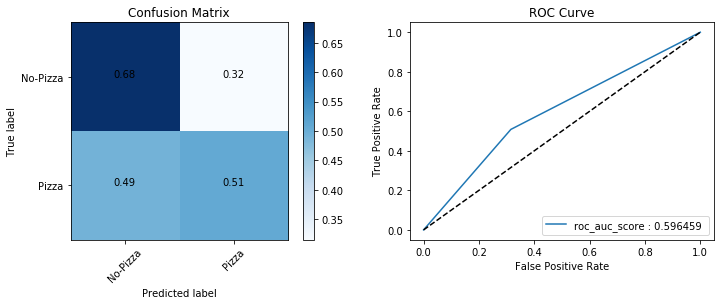

In [18]:
evaluate(class_names,dev_labels,predicted,True)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

y=train_labels
X=train_data
class_weight='balanced'
rfclf = RandomForestClassifier(n_estimators=300,max_features='sqrt',max_depth=80,min_samples_leaf=1,bootstrap=True,min_samples_split=11,class_weight=class_weight)
rfclf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=11, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [20]:
X_test=dev_data
y_test=dev_labels
y_pred = rfclf.predict(X_test)
print('Accuracy of classifier on dev set: {:.2f}'.format(rfclf.score(X_test, y_test)))
print('LogLoss : {score}'.format(score=log_loss(y_test, y_pred)))

Accuracy of classifier on dev set: 0.70
LogLoss : 10.430129453577905


              precision    recall  f1-score   support

       False       0.78      0.83      0.81       913
        True       0.36      0.30      0.33       299

   micro avg       0.70      0.70      0.70      1212
   macro avg       0.57      0.56      0.57      1212
weighted avg       0.68      0.70      0.69      1212

roc_auc_score : 0.563397 


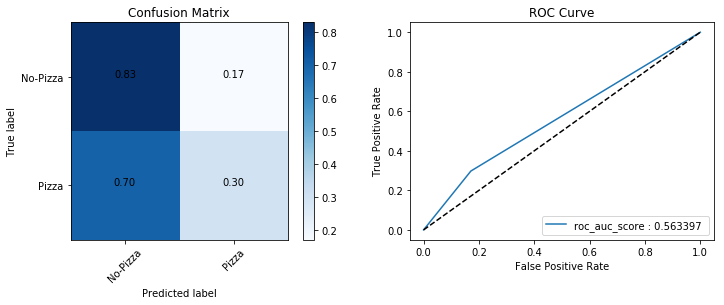

In [21]:
evaluate(class_names,dev_labels,y_pred,True)

In [22]:
predictions=[]
predictions.append(rfclf.predict_proba(X_test))
X_dev = vectorizer.transform(dev_data_text)
predictions.append(gs_clf.predict_proba(X_dev))

In [23]:
dev_probabilities=[int(k) for k in dev_labels]

In [24]:
def log_loss_func(weights):
    final_prediction = 0
    ''' scipy minimize will pass the weights as a numpy array '''
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(dev_probabilities, final_prediction)
    #return metrics.recall_score(dev_probabilities, final_prediction)

In [25]:
starting_values = [0.5]*len(predictions)

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensemble Score: 0.587274958187204
Best Weights: [0.98298454 0.01701546]


In [26]:
weights=res['x']
#weights=starting_values
y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(dev_data))]
y_pred=[True if k > 0.52 else False for k in y_pred]

              precision    recall  f1-score   support

       False       0.78      0.86      0.82       913
        True       0.37      0.25      0.30       299

   micro avg       0.71      0.71      0.71      1212
   macro avg       0.57      0.56      0.56      1212
weighted avg       0.68      0.71      0.69      1212

roc_auc_score : 0.556444 


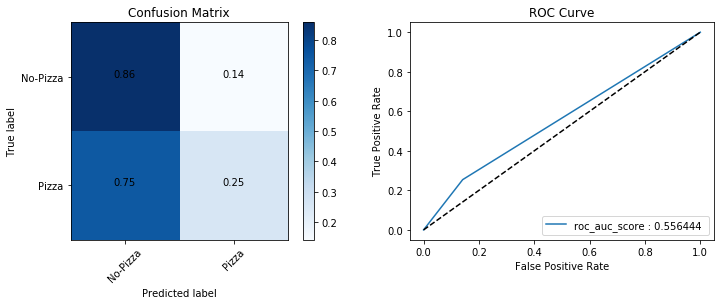

In [27]:
evaluate(class_names,dev_labels,y_pred,True)

## Kaggle Submission

In [28]:
data = pd.read_json("data/test.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
test_requests_id=data['request_id']
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
#data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)

In [29]:
data.requester_days_since_first_post_on_raop_at_request=data.requester_days_since_first_post_on_raop_at_request.astype(int)

In [30]:
data.shape

(1631, 14)

In [31]:
test_data_text = data["request_text_edit_aware"]
test_data=data.drop(['request_text_edit_aware'], axis=1)

In [32]:
predictions=[]
predictions.append(rfclf.predict_proba(test_data))
X_test = vectorizer.transform(test_data_text)
predictions.append(gs_clf.predict_proba(X_test))

In [33]:
weights=res['x']
#weights=starting_values
y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(test_data))]
y_pred=[True if k > 0.52 else False for k in y_pred]

In [34]:
x = np.array(y_pred).reshape(-1,1)
final_df = pd.DataFrame.from_records(x,columns=['requester_received_pizza'])

In [35]:
final_df=final_df.join(test_requests_id)
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]
final_df.requester_received_pizza=final_df.requester_received_pizza.astype(int)

In [36]:
final_df.groupby(['requester_received_pizza']).size()

requester_received_pizza
0    1374
1     257
dtype: int64

In [37]:
final_df.head(1)

,request_id,requester_received_pizza
0,t3_i8iy4,1


In [38]:
final_df.to_csv('/tmp/final_submission.csv',header=True,index=False)